## Credit Card Fraud Detection

## Imports Libraries

In [2]:
# Settings and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# imbalance tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
SAMPLE = None   # set to e.g. 20000 for faster prototyping, or None to use full data

## Load dataset

In [3]:
DATA_PATH = "creditcard.csv"

df = pd.read_csv(DATA_PATH)
print("Dataset loaded. Shape:", df.shape)
display(df.head())

# Basic info & missing values
print("\n--- Info ---")
display(df.info())
print("\n--- Missing values per column ---")
display(df.isnull().sum())

# Numeric summary for numeric features
print("\n--- Describe (numeric) ---")
display(df.describe().T)

Dataset loaded. Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

None


--- Missing values per column ---


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


--- Describe (numeric) ---


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


## Quick EDA: class imbalance & visualize

Class distribution:


Class
0    284315
1       492
Name: count, dtype: int64

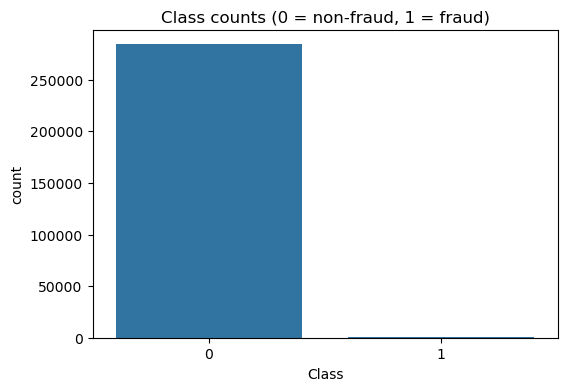

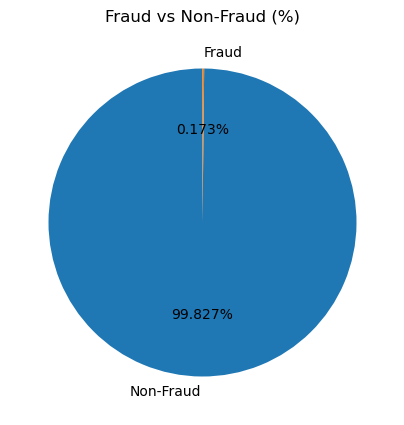

In [4]:
# Class counts
print("Class distribution:")
class_counts = df['Class'].value_counts()
display(class_counts)

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class counts (0 = non-fraud, 1 = fraud)")
plt.show()

# Pie chart
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['Non-Fraud','Fraud'], autopct='%1.3f%%', startangle=90)
plt.title("Fraud vs Non-Fraud (%)")
plt.show()

## Feature distributions and outliers

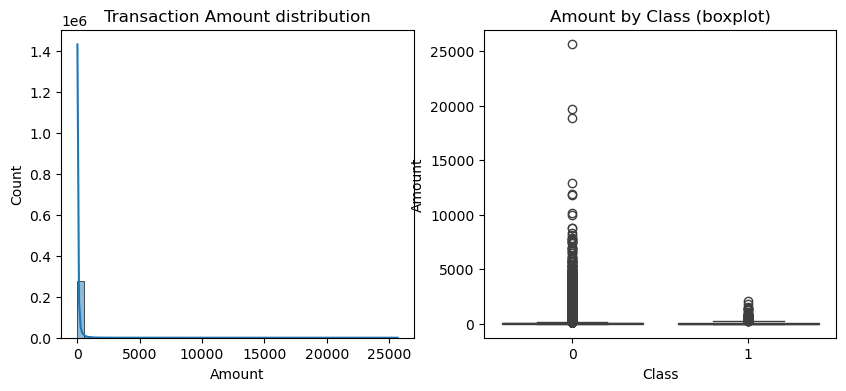

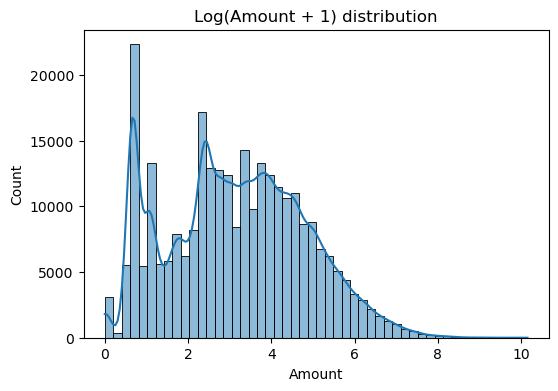

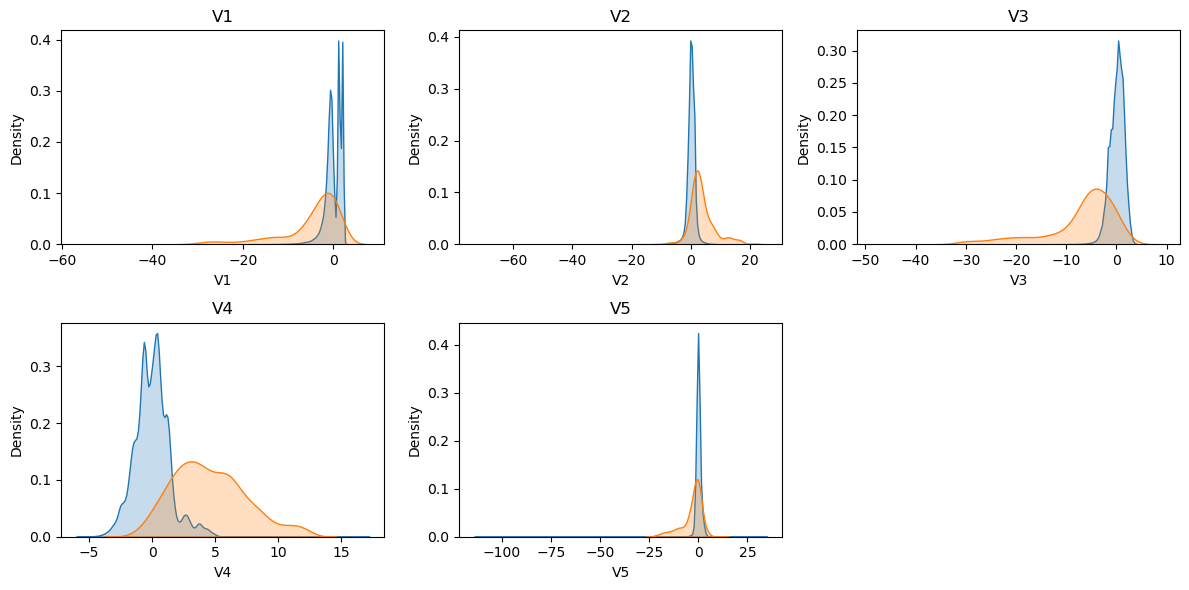

In [5]:
# Distribution of Amount (whole dataset)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount distribution")

plt.subplot(1,2,2)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Amount by Class (boxplot)")
plt.show()

# Log-transform visualization to see heavy tails
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df['Amount']), bins=50, kde=True)
plt.title("Log(Amount + 1) distribution")
plt.show()

# Compare distributions of a few PCA features (V1..V5) for fraud vs non-fraud
cols = df.columns[1:6]  # V1..V5
plt.figure(figsize=(12,6))
for i, c in enumerate(cols, 1):
    plt.subplot(2,3,i)
    sns.kdeplot(df.loc[df['Class']==0, c], label='Non-Fraud', shade=True)
    sns.kdeplot(df.loc[df['Class']==1, c], label='Fraud', shade=True)
    plt.title(c)
plt.tight_layout()
plt.show()

## Correlation heatmap

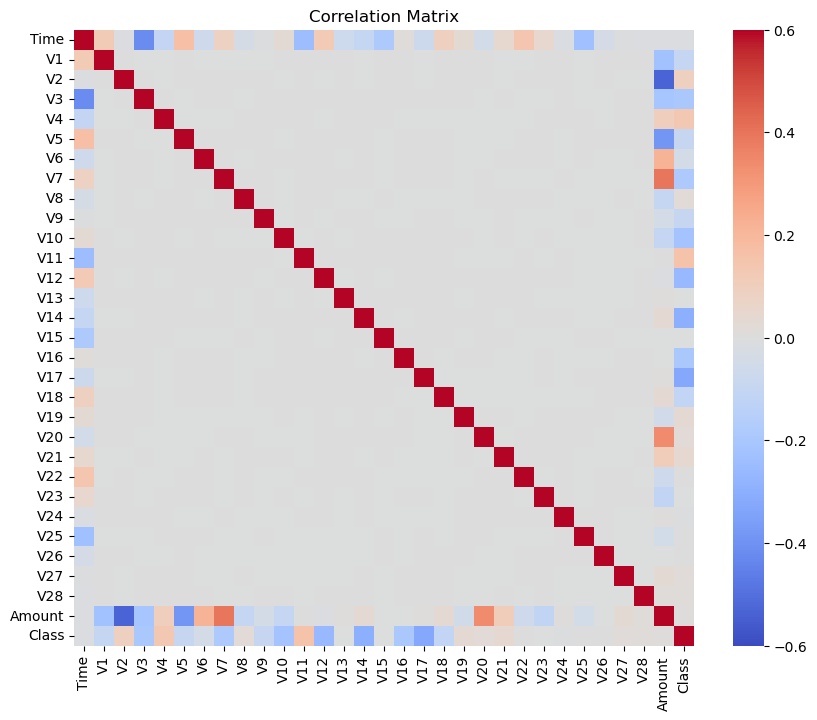

In [6]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=0.6, vmin=-0.6)
plt.title("Correlation Matrix")
plt.show()

## Preprocessing: features, train/test split, scaling

In [8]:
# Prepare X and y
X = df.drop('Class', axis=1)
y = df['Class'].values

# Often we scale Amount and Time; PCA V1..V28 are pre-scaled
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
# optionally scale Time:
# X_scaled['Time'] = scaler.fit_transform(X[['Time']])

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print("Train/test shapes:", X_train.shape, X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))

Train/test shapes: (227845, 30) (56962, 30)
Train class counts: [227451    394]
Test class counts: [56864    98]


## Baseline models: instantiate

In [10]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
    "SVM": SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}

# We'll store trained results here
baseline_results = {}

## train, predict, and evaluate

In [11]:
from collections import OrderedDict

def fit_and_evaluate(model, X_train, y_train, X_test, y_test, name="model"):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        # decision_function -> map to probabilities via sigmoid (for ranking/ROC)
        y_proba = model.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)

    result = OrderedDict([
        ("name", name),
        ("model", model),
        ("train_time_sec", train_time),
        ("accuracy", acc),
        ("precision", prec),
        ("recall", rec),
        ("f1", f1),
        ("roc_auc", auc),
        ("confusion_matrix", cm),
        ("y_pred", y_pred),
        ("y_proba", y_proba)
    ])
    print(f"{name}: acc={acc:.4f}, prec={prec:.4f}, recall={rec:.4f}, f1={f1:.4f}, auc={auc if auc else 'None'}, time={train_time:.1f}s")
    return result

## Train baseline models

In [12]:
for name, model in models.items():
    print("Training:", name)
    res = fit_and_evaluate(model, X_train, y_train, X_test, y_test, name=name)
    baseline_results[name] = res

Training: LogisticRegression
LogisticRegression: acc=0.9746, prec=0.0588, recall=0.9184, f1=0.1105, auc=0.9723350844980648, time=55.2s
Training: DecisionTree
DecisionTree: acc=0.9989, prec=0.6762, recall=0.7245, f1=0.6995, auc=0.8619459390396564, time=34.8s
Training: RandomForest
RandomForest: acc=0.9995, prec=0.9605, recall=0.7449, f1=0.8391, auc=0.952908497036969, time=75.7s
Training: XGBoost
XGBoost: acc=0.9994, prec=0.8667, recall=0.7959, f1=0.8298, auc=0.9389517272862999, time=4.9s
Training: SVM
SVM: acc=0.9983, prec=0.0000, recall=0.0000, f1=0.0000, auc=0.6188349143821851, time=576.4s


## Baseline summary table

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,TrainTimeSec
0,LogisticRegression,0.974562,0.058785,0.918367,0.110497,0.972335,55.178952
2,RandomForest,0.999508,0.960526,0.744898,0.839080,0.952908,75.720456
3,XGBoost,0.999438,0.866667,0.795918,0.829787,0.938952,4.885093
1,DecisionTree,0.998929,0.676190,0.724490,0.699507,0.861946,34.829090
4,SVM,0.998280,0.000000,0.000000,0.000000,0.618835,576.446314


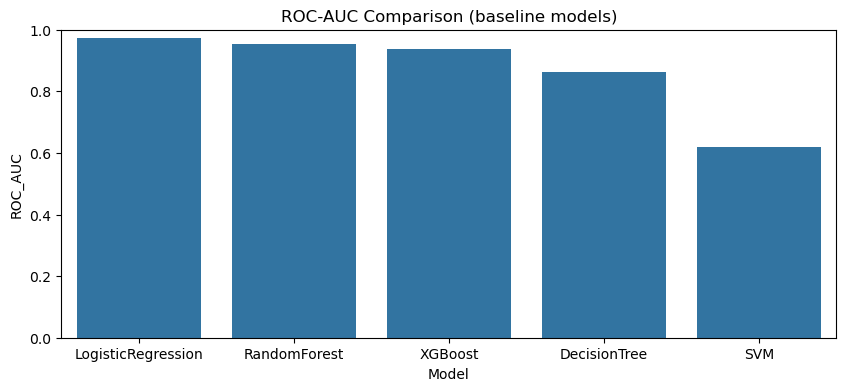

In [13]:
summary = pd.DataFrame([
    {
        "Model": r["name"],
        "Accuracy": r["accuracy"],
        "Precision": r["precision"],
        "Recall": r["recall"],
        "F1": r["f1"],
        "ROC_AUC": r["roc_auc"],
        "TrainTimeSec": r["train_time_sec"]
    } for r in baseline_results.values()
]).sort_values("ROC_AUC", ascending=False)

display(summary)
plt.figure(figsize=(10,4))
sns.barplot(x="Model", y="ROC_AUC", data=summary)
plt.title("ROC-AUC Comparison (baseline models)")
plt.ylim(0.0,1.0)
plt.show()

## Confusion matrices (visual) for baseline models

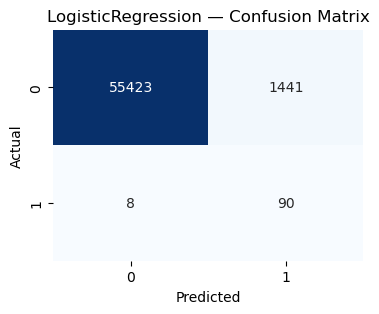

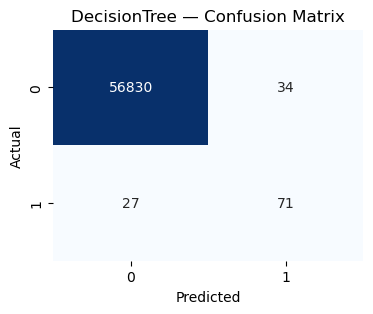

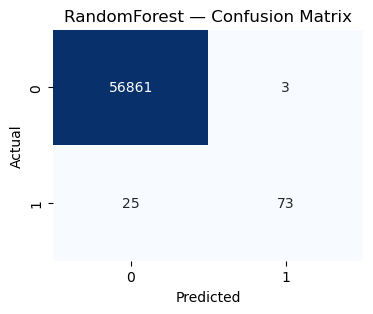

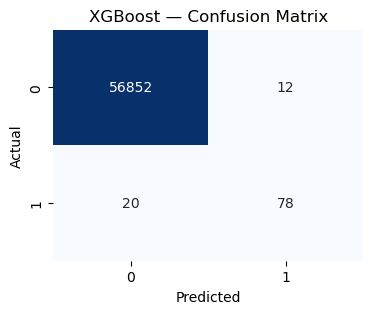

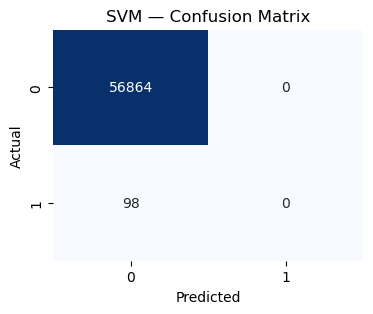

In [14]:
for name, r in baseline_results.items():
    cm = r["confusion_matrix"]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## ROC curves for all models on same plot

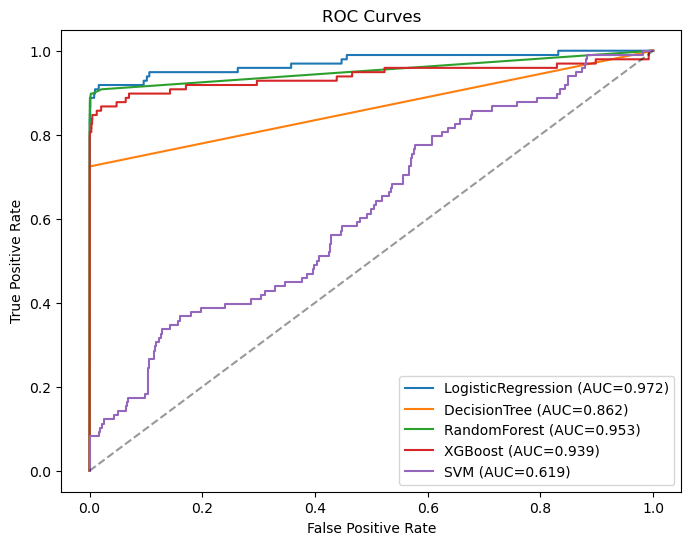

In [15]:
plt.figure(figsize=(8,6))
for name, r in baseline_results.items():
    y_proba = r["y_proba"]
    if y_proba is None:
        print(f"No probability/score for {name}; skipping ROC.")
        continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()

## Precision-Recall curves for all models

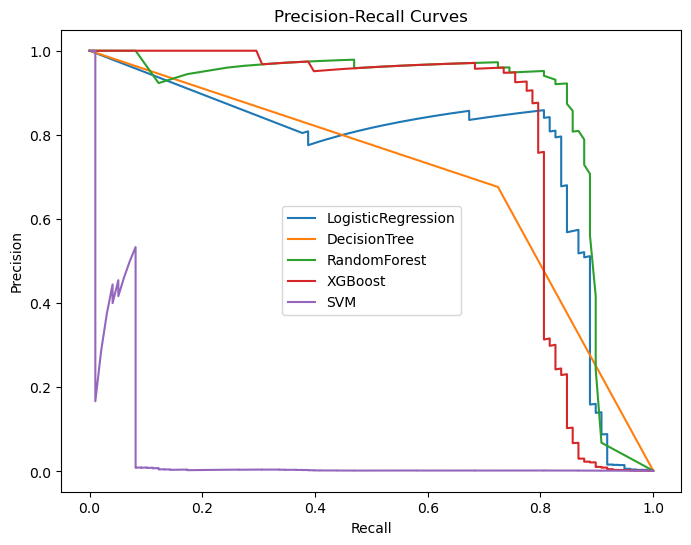

In [16]:
plt.figure(figsize=(8,6))
for name, r in baseline_results.items():
    y_proba = r["y_proba"]
    if y_proba is None:
        continue
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    avg_prec = np.trapz(prec, rec)  # approximate area under PR curve (not the official AP)
    plt.plot(rec, prec, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

## Model improvements: SMOTE oversampling

In [18]:
sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE, training class distribution:", np.bincount(y_res))

models_to_try = {
    "Logistic_SMOTE": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest_SMOTE": RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=RANDOM_STATE),
    "XGBoost_SMOTE": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
}

smote_results = {}
for name, model in models_to_try.items():
    print("Training with SMOTE:", name)
    res = fit_and_evaluate(model, X_res, y_res, X_test, y_test, name=name)
    smote_results[name] = res

# Compare baseline vs smote
all_results = {**baseline_results, **smote_results}
summary2 = pd.DataFrame([
    {
        "Model": r["name"],
        "Accuracy": r["accuracy"],
        "Precision": r["precision"],
        "Recall": r["recall"],
        "F1": r["f1"],
        "ROC_AUC": r["roc_auc"],
        "TrainTimeSec": r["train_time_sec"]
    } for r in all_results.values()
]).sort_values("Recall", ascending=False)
display(summary2)

After SMOTE, training class distribution: [227451 227451]
Training with SMOTE: Logistic_SMOTE
Logistic_SMOTE: acc=0.9877, prec=0.1140, recall=0.9082, f1=0.2025, auc=0.9763996517290089, time=84.6s
Training with SMOTE: RandomForest_SMOTE
RandomForest_SMOTE: acc=0.9994, prec=0.8265, recall=0.8265, f1=0.8265, auc=0.9691768150000575, time=1536.6s
Training with SMOTE: XGBoost_SMOTE
XGBoost_SMOTE: acc=0.9993, prec=0.7727, recall=0.8673, f1=0.8173, auc=0.9788973763393934, time=9.3s


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,TrainTimeSec
0,LogisticRegression,0.974562,0.058785,0.918367,0.110497,0.972335,55.178952
5,Logistic_SMOTE,0.987694,0.113956,0.908163,0.202503,0.976400,84.552544
7,XGBoost_SMOTE,0.999333,0.772727,0.867347,0.817308,0.978897,9.324279
6,RandomForest_SMOTE,0.999403,0.826531,0.826531,0.826531,0.969177,1536.577732
3,XGBoost,0.999438,0.866667,0.795918,0.829787,0.938952,4.885093
2,RandomForest,0.999508,0.960526,0.744898,0.839080,0.952908,75.720456
1,DecisionTree,0.998929,0.676190,0.724490,0.699507,0.861946,34.829090
4,SVM,0.998280,0.000000,0.000000,0.000000,0.618835,576.446314


## Model improvements: Random undersampling

In [19]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print("After undersampling, class distribution:", np.bincount(y_rus))

# Train a random forest on undersampled data
rf_under = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
res_rf_under = fit_and_evaluate(rf_under, X_rus, y_rus, X_test, y_test, name="RF_Undersampled")

After undersampling, class distribution: [394 394]
RF_Undersampled: acc=0.9641, prec=0.0423, recall=0.9184, f1=0.0809, auc=0.9776977722715422, time=0.7s


## Decision threshold tuning

Chosen threshold for recall >= 0.8: 1.0000, precision=0.8587
Metrics at chosen threshold:
Precision: 0.8586956521739131
Recall   : 0.8061224489795918
F1       : 0.8315789473684211
Confusion matrix:
 [[56851    13]
 [   19    79]]


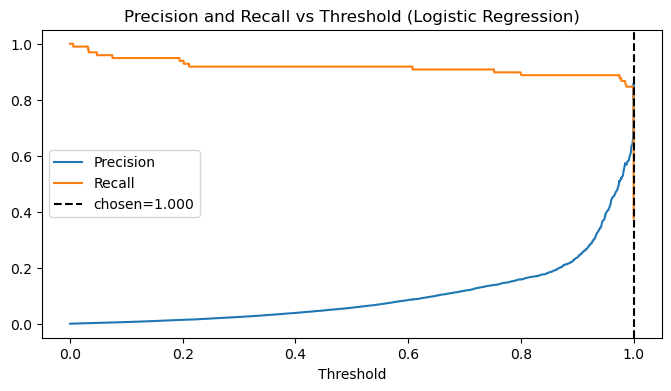

In [20]:
# Use the baseline LogisticRegression model that supports predict_proba
lr_baseline = baseline_results.get("LogisticRegression")["model"]
y_scores = baseline_results.get("LogisticRegression")["y_proba"]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Create a DataFrame to inspect thresholds with precision/recall
pr_df = pd.DataFrame({"precision": precisions[:-1], "recall": recalls[:-1], "threshold": thresholds})
# Find threshold that gives recall >= 0.8 (for example)
target_recall = 0.8
candidates = pr_df[pr_df['recall'] >= target_recall]
if not candidates.empty:
    chosen = candidates.iloc[candidates['precision'].idxmax()]  # pick highest precision at that recall
    chosen_thresh = chosen['threshold']
    print(f"Chosen threshold for recall >= {target_recall}: {chosen_thresh:.4f}, precision={chosen['precision']:.4f}")
else:
    chosen_thresh = 0.5
    print("No threshold achieves the target recall; using 0.5")

# Evaluate at this threshold
y_pred_thresh = (y_scores >= chosen_thresh).astype(int)
print("Metrics at chosen threshold:")
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall   :", recall_score(y_test, y_pred_thresh))
print("F1       :", f1_score(y_test, y_pred_thresh))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_thresh))

# Plot precision-recall vs threshold
plt.figure(figsize=(8,4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(chosen_thresh, color='k', linestyle='--', label=f"chosen={chosen_thresh:.3f}")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision and Recall vs Threshold (Logistic Regression)")
plt.show()

## Compare improved models (final table & plots)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,TrainTimeSec
0,LogisticRegression,0.974562,0.058785,0.918367,0.110497,0.972335,55.178952
8,RF_Undersampled,0.964099,0.042313,0.918367,0.080899,0.977698,0.668797
5,Logistic_SMOTE,0.987694,0.113956,0.908163,0.202503,0.976400,84.552544
7,XGBoost_SMOTE,0.999333,0.772727,0.867347,0.817308,0.978897,9.324279
6,RandomForest_SMOTE,0.999403,0.826531,0.826531,0.826531,0.969177,1536.577732
3,XGBoost,0.999438,0.866667,0.795918,0.829787,0.938952,4.885093
2,RandomForest,0.999508,0.960526,0.744898,0.839080,0.952908,75.720456
1,DecisionTree,0.998929,0.676190,0.724490,0.699507,0.861946,34.829090
4,SVM,0.998280,0.000000,0.000000,0.000000,0.618835,576.446314


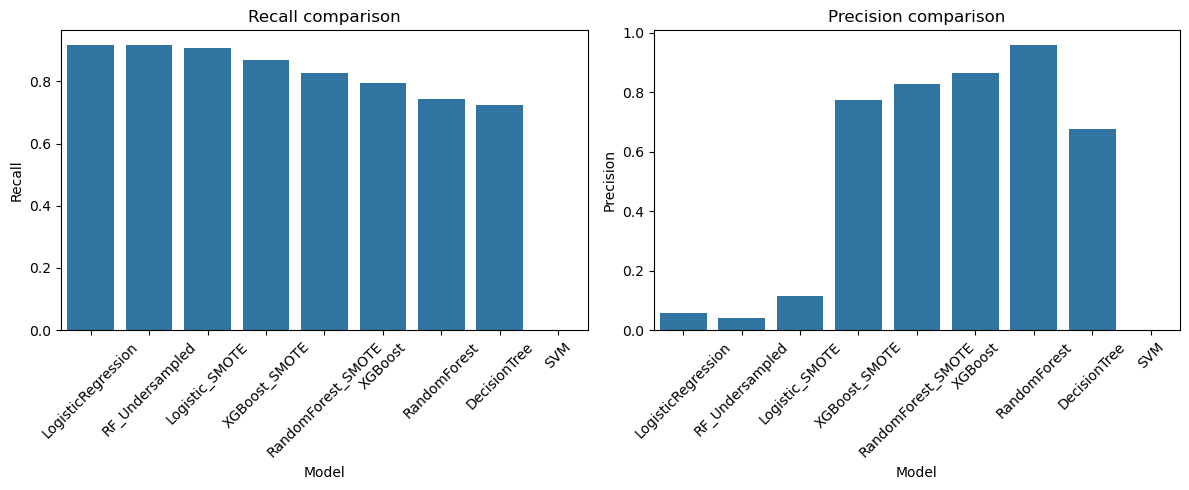

In [21]:
# combine all results we have into a single dictionary
combined_results = {**baseline_results}
combined_results.update(smote_results)
combined_results["RF_Undersampled"] = res_rf_under

final_summary = pd.DataFrame([
    {
        "Model": r["name"],
        "Accuracy": r["accuracy"],
        "Precision": r["precision"],
        "Recall": r["recall"],
        "F1": r["f1"],
        "ROC_AUC": r["roc_auc"],
        "TrainTimeSec": r["train_time_sec"]
    } for r in combined_results.values()
]).sort_values("Recall", ascending=False)

display(final_summary)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x="Model", y="Recall", data=final_summary)
plt.xticks(rotation=45)
plt.title("Recall comparison")

plt.subplot(1,2,2)
sns.barplot(x="Model", y="Precision", data=final_summary)
plt.xticks(rotation=45)
plt.title("Precision comparison")
plt.tight_layout()
plt.show()

## Error analysis: show some misclassified examples

In [22]:
def show_misclassified(r):
    y_pred = r["y_pred"]
    name = r["name"]
    cm = r["confusion_matrix"]
    print(f"\nModel: {name}")
    print("Confusion matrix:\n", cm)
    # indices where predicted != true
    mis_idx = np.where(y_test != y_pred)[0]
    # show up to 10 misclassified rows with true/pred/prob
    display_count = min(10, len(mis_idx))
    rows = []
    for i in range(display_count):
        idx = mis_idx[i]
        prob = None
        if r["y_proba"] is not None:
            # get the model probability for class 1
            prob = float(r["y_proba"][idx])
        rows.append({
            "index": idx,
            "true": int(y_test[idx]),
            "pred": int(y_pred[idx]),
            "proba": prob,
            **X_test.iloc[idx].to_dict()
        })
    display(pd.DataFrame(rows))

# Example: display for RandomForest baseline
show_misclassified(baseline_results['RandomForest'])


Model: RandomForest
Confusion matrix:
 [[56861     3]
 [   25    73]]


,index,true,pred,proba,Time,V1,V2,V3,V4,V5,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,165,0,1,0.56,128759.0,-1.272117,1.827615,-3.810610,0.583759,-0.641242,...,-0.027268,0.858998,0.858775,0.083079,0.741676,-0.173234,0.534870,0.183562,0.020316,-0.350191
1,2777,0,1,0.90,26217.0,-17.950631,11.067069,-20.742660,6.075531,-13.389765,...,1.712909,1.797134,-1.275675,-0.705046,0.102040,1.177477,-0.238730,1.554463,0.547948,-0.349231
2,4276,1,0,0.41,43494.0,-1.278138,0.716242,-1.143279,0.217805,-1.293890,...,0.817203,0.490183,0.470427,-0.126261,-0.126644,-0.661908,-0.349793,0.454851,0.137843,-0.253677
3,9156,1,0,0.41,53937.0,-2.042608,1.573578,-2.372652,-0.572676,-2.097353,...,0.825566,-0.723326,0.501222,-0.696892,-0.600514,0.127547,-0.786072,0.606097,0.171697,0.693749
4,9179,1,0,0.30,25198.0,-15.903635,10.393917,-19.133602,6.185969,-12.538021,...,1.501565,1.577548,-1.280137,-0.601295,0.040404,0.995502,-0.273743,1.688136,0.527831,0.046539
5,12266,1,0,0.14,12393.0,-4.064005,3.100935,-1.188498,3.264633,-1.903562,...,-0.531898,1.688665,-0.078845,0.193731,0.479496,-0.506603,-0.409863,-3.036271,-0.630605,0.365067
6,12588,1,0,0.33,96717.0,-3.705856,4.107873,-3.803656,1.710314,-3.582466,...,3.639603,-5.498772,2.941475,0.916236,-0.255504,-0.183835,-0.584539,-0.315484,-0.097223,-0.349231
7,16715,1,0,0.48,29785.0,0.923764,0.344048,-2.880004,1.721680,-3.019565,...,0.170872,0.899931,1.481271,0.725266,0.176960,-1.815638,-0.536517,0.489035,-0.049729,-0.232087
8,17046,1,0,0.00,44532.0,-0.234922,0.355413,1.972183,-1.255593,-0.681387,...,-0.003469,0.220670,0.912107,-0.286338,0.451208,0.188315,-0.531846,0.123185,0.039581,-0.349231
9,20992,1,0,0.00,110087.0,1.934946,0.650678,-0.286957,3.987828,0.316052,...,-0.344452,-0.173602,-0.190974,0.219976,-0.216597,-0.136692,-0.129954,-0.050077,-0.051082,-0.349231


## Task Is Done ! 